# Data loading

In [1]:
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [2]:
jar = pd.read_csv('clean_data.csv')

fdData = [[] for _ in range(7)]
fdVals = jar['FD'].unique()

for i, val in enumerate(fdVals):
    fd = jar[jar['FD'] == val]
    fd = fd.drop(['FD', 'fuel_gas_swelling'], axis=1)
    fdData[i] = fd

In [3]:
def swelling_perc(fd):
    return 6.13e-43 * fd**2 + 4e-21 * fd

1 4.613 4.351 0.030
2 10.452 8.326 0.052
3 17.517 12.820 0.169
4 25.808 19.753 0.925
5 35.325 30.114 2.113
6 46.068 41.297 3.359
7 58.037 53.856 4.820


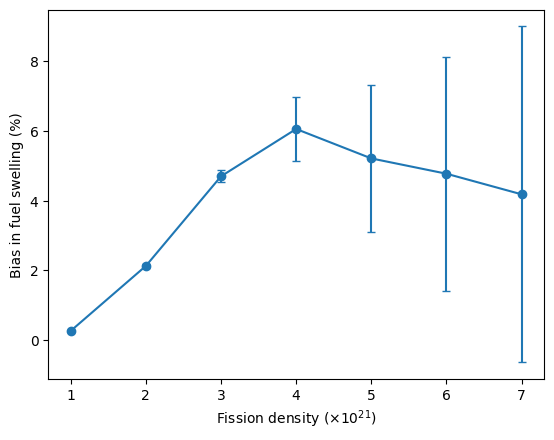

In [4]:
bias = []
errs = []
for i in range(1, 8):
    obs = swelling_perc(i * 1e21)
    dar = mean(fdData[i-1]['fuel_swelling'])
    err = stdev(fdData[i-1]['fuel_swelling'])
    print(f'{i} {obs:.3f} {dar:.3f} {err:.3f}')
    
    bias.append(obs - dar)
    errs.append(err)

fds = [i for i in range(1, 8)]
plt.errorbar(fds, bias, errs, marker='o', capsize=3)

plt.xlabel(r'Fission density ($\times 10^{21}$)')
plt.ylabel('Bias in fuel swelling (%)')
plt.show()

In [5]:
print(bias)

[0.26161284374999916, 2.1255391249999995, 4.697419374999999, 6.055176875000001, 5.210816562500003, 4.771403437499998, 4.1805637499999975]


# Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
xscaler = StandardScaler()

In [8]:
X_train = xscaler.fit_transform(fdVals.reshape(-1,1))
y_train = np.array(bias)
noise_train = np.array(errs)

# GP emulator

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

Optimize the GP emulator later.

In [10]:
gp = GaussianProcessRegressor(
    kernel = 1 * RBF(length_scale=0.1),
    alpha = noise_train)

gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=array([0.02981037, 0.05164183, 0.16901081, 0.92506209, 2.1125283 ,
       3.35867552, 4.82021625]),
                         kernel=1**2 * RBF(length_scale=0.1))

In [11]:
X_test = np.linspace(-2, 2, num=50).reshape(-1,1)
mean_pred, std_pred = gp.predict(X_test, return_std=True)

# Polynomial fit

In [12]:
z = np.polyfit(X_train.ravel(), y_train, 2)
p = np.poly1d(z)
poly_pred = [p(i) for i in X_test]

In [13]:
z

array([-1.52667051,  1.2422291 ,  5.42703222])

# Plotting

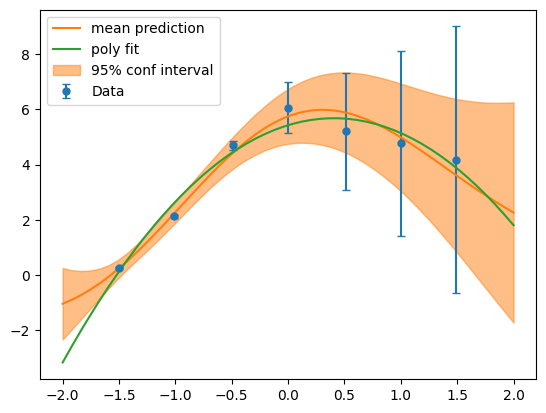

In [14]:
plt.errorbar(X_train, y_train, noise_train,
             ls='None', marker='.', markersize=10, capsize=3,
             color='tab:blue', label='Data')
plt.plot(X_test, mean_pred, color='tab:orange', label='mean prediction')
plt.plot(X_test, poly_pred, color='tab:green', label='poly fit')
plt.fill_between(X_test.ravel(), mean_pred - 1.96 * std_pred,
                 mean_pred + 1.96 * std_pred, alpha=0.5,
                 color='tab:orange', label='95% conf interval')
plt.legend()
plt.show()

# Save model

Remember X is standardized!

In [15]:
import pickle

In [16]:
with open('gp_bias.pkl', 'wb') as file:
    pickle.dump(gp, file)